**Import Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_curve, auc

**Load In-Distribution & OOD Data**

In [6]:
# In-Distribution dataset
(X_train, y_train), (x_test, y_test)= mnist.load_data()

# Out-of-distribution dataset
(x_ood, y_ood), _ = fashion_mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step 
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Preprocessing**

In [8]:
x_train = X_train / 255.0
x_test = x_test / 255.0
x_ood = x_ood / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

**Build Classifier**

model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')

])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']

) 

**Train Model**

In [10]:
model.fit(
    x_train, y_train_cat,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8963 - loss: 0.3691 - val_accuracy: 0.9582 - val_loss: 0.1483
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9549 - loss: 0.1521 - val_accuracy: 0.9692 - val_loss: 0.1165
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9688 - loss: 0.1071 - val_accuracy: 0.9733 - val_loss: 0.0983
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9756 - loss: 0.0811 - val_accuracy: 0.9750 - val_loss: 0.0856
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9805 - loss: 0.0646 - val_accuracy: 0.9762 - val_loss: 0.0858


**Confidence Scores**

In [12]:
def max_softmax_confidence(model, X):
    probs = model.predict(X, verbose=0)
    return np.max(probs, axis=1)

**Compute confidence for ID vs OOD**

In [15]:
conf_id = max_softmax_confidence(model, x_test)
conf_ood = max_softmax_confidence(model, x_ood[:len(x_test)])

print(type(conf_id), conf_id.shape)
print(type(conf_ood), conf_ood.shape)

<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (10000,)


In [19]:
print(type(conf_id))
print(conf_id.shape)
print(conf_id.dtype)
print(conf_id[:5])

<class 'numpy.ndarray'>
(10000,)
float32
[0.9991918  0.9986284  0.9962398  0.9998851  0.99223715]


In [20]:
conf_id = np.asarray(conf_id, dtype=float).ravel()
conf_ood = np.asarray(conf_ood, dtype=float).ravel()

**Confidence Distribution Plot**

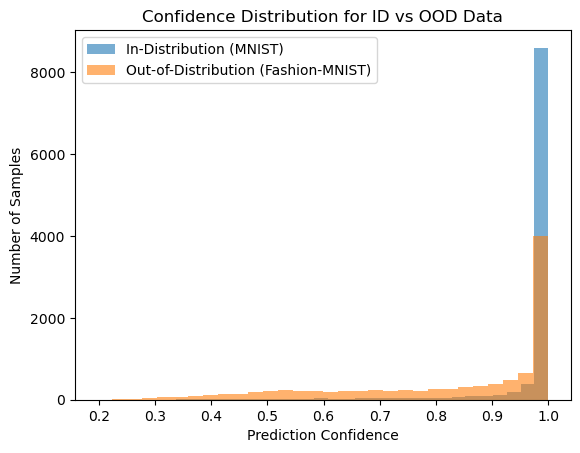

In [22]:
plt.figure()
plt.hist(conf_id, bins=30, alpha=0.6, label="In-Distribution (MNIST)")
plt.hist(conf_ood, bins=30, alpha=0.6, label="Out-of-Distribution (Fashion-MNIST)")
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Samples")
plt.title("Confidence Distribution for ID vs OOD Data")
plt.legend()
plt.show()


**OOD Detection ROC Curve**

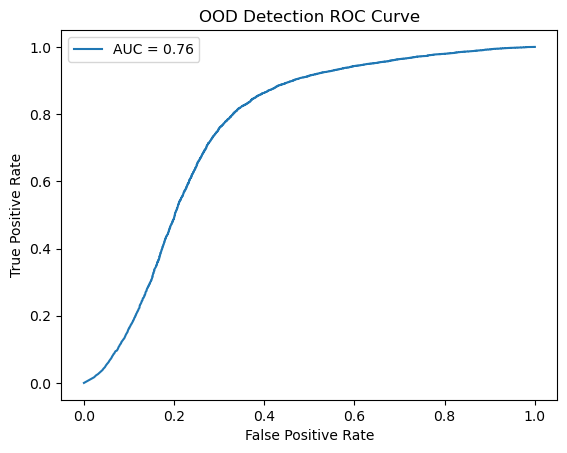

In [23]:
labels = np.concatenate([
    np.ones(len(conf_id)),       # In-distribution
    np.zeros(len(conf_ood))      # OOD
])

scores = np.concatenate([conf_id, conf_ood])

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOD Detection ROC Curve")
plt.legend()
plt.show()